In [1]:
!pip install transformers
!pip install datasets
# !pip install wandb


In [11]:
!pip install xformers

In [3]:
import torch
print(torch.cuda.is_available())

True


In [17]:
import torch.nn as nn
import torch
from transformers import pipeline, set_seed
from transformers import GPT2Tokenizer


class MLP(nn.Module):
    ## multi layer perceptron thats inserted into distilgpt2
    ## function is simple, its 2 linear layers that take the output of the transformer in distilgpt2 and it learns to steer the text into making better prompts
    ## however, we only want to update parameters for the 2 linear layers, not the rest, hence the requires grad being set to false
    ## output of the lm_head in this case is our Q value
    ## lm_head outputs 50k size tensors, and it's argmax is the token that it represents (aka which word to pick out of the 50k vocab size)
    ## according to the paper, this 50k size tensor also represents Q value since it decides which word to pick for our prompt
    ## our 2 linear layers get fed in states aka the previous prompts that we've generated
    ## they learn the appropriate Q value that the lm_head should output for the action of picking a word based on current reward and discounted max future reward (aka the target)
    def __init__(self):
        super().__init__()
        self.lm_pipeline = pipeline('text-generation', model='distilgpt2')
        self.policy = nn.Sequential(
            nn.Linear(768, 2048),
            nn.ReLU(),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Linear(2048, 768),
#             nn.ReLU(),
        )
        def _init_weights(m):
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.0001)
                m.bias.data.fill_(-0.0001)
        self.policy.apply(_init_weights)
        self.lm_pipeline.model.lm_head.requires_grad_(False)
        self.lm_pipeline.model.transformer.requires_grad_(False)
        self.lm_pipeline.model.lm_head = self.lm_pipeline.model.lm_head.to(device)
        self.lm_pipeline.model.transformer = self.lm_pipeline.model.transformer.to(device)
        self.tokenizer = GPT2Tokenizer.from_pretrained('distilgpt2', truncation_side = 'left')
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.lm_pipeline.model.train()
    def forward(self, x):
        # assert(x.shape[1] == 768)
        # print(x.shape)
        x = self.policy(x)
        return self.lm_pipeline.model.lm_head(x)
    def truncate(self, x):
        arr1 = []
        arr2 = []
        for i in x:
            token = self.tokenizer([i], return_tensors = 'pt')
            inp = token['input_ids'][0,-3:]
            masks = token['attention_mask'][0,-3:]
            arr1.append(inp)
            arr2.append(masks)
        return {'input_ids':torch.cat(arr1).reshape(len(x),-1), 'attention_mask': torch.cat(arr2).reshape(len(x),-1)}
            
    def get_lm_output(self, x):
        with torch.no_grad():
          input = self.truncate(x)
          for key, value in zip(input.keys(), input.values()):
            input[key] = value.to(device)
          return self.lm_pipeline.model.transformer(**input, use_cache=True).last_hidden_state
    def get_prompt(self, x):
        # print(x.shape)
        return  (self.lm_pipeline.tokenizer.convert_ids_to_tokens(x.softmax(-1).argmax(-1).reshape(1))[0]).replace('Ġ','')
    def get_prompt_greedy(self, x, epsilon):
        # print(x.shape)
        if torch.rand(1) < epsilon:
            return  self.lm_pipeline.tokenizer.decode(torch.randint(0, x.shape[-1], (1,)))
        return  self.lm_pipeline.tokenizer.decode(x.softmax(-1).argmax(-1).reshape(1))
    def get_prompt_softmax_greedy(self, x):
        # print(x.shape)
        return  self.lm_pipeline.tokenizer.decode()
    

In [18]:
from transformers import pipeline

import torch
device = "cpu"

class MLM():
  ### Our masked LM model
  ### no learning involved here, just try to get the reward for having it fill it with good vs bad
  def __init__(self):
   self.unmasker = pipeline('fill-mask', model='distilroberta-base')

  def get_masked_word_class(self, input, prompt):
    return self.unmasker(f'{input} {prompt} <mask>', targets = ['good', 'bad'])




In [31]:

import torch
from tqdm import tqdm
# import wandb
### we have states which represents words that we feed into the distilgpt to get better words/prompts
### prompt at time t is a result of picking the action from the mlp that results in the highest reward
### can be written as argmax(reward(MLP(states)), arg = prompt)
### our loss/regression target is essentially reward+discount*max(Q(s_t+1, a'_t+1) for all a')
### this technically isn't the softqlearner, and is generally unstable and produces sparse rewards and takes an extremely long time to train
class QLearner():

    def __init__(self):
        self.mlm = MLM()
        self.mlp = MLP().to(device)
        self.target = MLP().to(device)
#         self.target.load_state_dict(self.mlp.state_dict())
        # torch.manual_seed(95)

        self.last_state = 'this'
        self.prompt_reward = [0]
        self.max_reward = 0
        self.optimizer = torch.optim.AdamW(self.mlp.parameters(), lr=1e-4)
        self.accuracy = []
        self.val_acc = []
        self.loss_ = []
        self.epsilon = .9
    def randomize(self, Q, epsilon): 
#         print("max, min ", Q.max(), Q.min())
        r = torch.rand(1)
#         print('before')
#         print(Q.argmax(-1))
        if r < epsilon:
            index = torch.randint(0, Q.shape[-1], (1,))
            
            m = Q.max().item()
            m = 1 if m == 0 else m
            detached = Q.detach()
#             print('index and max prob',index,m)
            detached[:] = 0
            detached[index] = m
#             print('prob:',r)
#         print('after')
#         print(Q.argmax(-1))
        return Q
    # gets the actions for every state, and their Q values. actions in this case are the prompts
    def get_actions_Q (self, last_state):
        actions = []
        Q = []
        for i in range(5):
          lm_output = self.mlp.get_lm_output([last_state]).to(device) 
          Q_ = self.mlp(lm_output)
          Q.append(Q_)
          last_state = self.mlp.get_prompt(Q_)
          actions.append(last_state)
        if type(actions) == str:
          actions = [actions]
        return actions, torch.cat(Q), last_state

    def get_actions_Q_target (self, last_state):
        actions = []
        Q = []
        for i in range(5):
          lm_output = self.target.get_lm_output([last_state]).to(device) 
          Q_ = self.target(lm_output)
          Q.append(Q_)
          last_state = self.target.get_prompt(Q_)
          actions.append(last_state)
        if type(actions) == str:
          actions = [actions]
        return actions, torch.cat(Q), last_state


    def get_actions_Q_input_specific (self, batch_input):
        actions = []
#         print(len(batch_input))
        lm_output = self.mlp.get_lm_output(batch_input).to(device) 
        Q_ = self.mlp(lm_output)
    
#         print(Q_.shape)
        Q_ = Q_[:,-1].reshape(Q_.shape[0], Q_.shape[-1]) #(16, 50k)
        for i in range(Q_.shape[0]):
          actions.append([self.mlp.get_prompt(Q_[i])])
        
        Q = [[self.randomize(Q_[i], self.epsilon).reshape(1, Q_.shape[-1])] for i in range(Q_.shape[0])]



        for i in range(1):
          lm_output = self.mlp.get_lm_output([ batch_input[j]+"".join(actions[j]) for j in range(len(actions))]).to(device) 
          Q_ = self.mlp(lm_output)
        
          Q_ = Q_[:,-1].reshape(Q_.shape[0], Q_.shape[-1])
          for j in range(Q_.shape[0]):
            Q[j].append(self.randomize(Q_[j], self.epsilon).reshape(1, Q_.shape[-1]))
          
          for j in range(Q_.shape[0]):
            actions[j].append(self.mlp.get_prompt(Q_[j]))
        if type(actions) == str:
          actions = [actions]
        # print(Q)
        # print(actions)
        Q = [torch.cat(Q__).reshape(1,2,-1) for Q__ in Q]
        # print(torch.cat(Q).shape)
        return actions, torch.cat(Q)

    def get_actions_Q_input_specific_target (self, batch_input):
        actions = []

        lm_output = self.target.get_lm_output(batch_input).to(device) 
        Q_ = self.target(lm_output)
        Q_ = Q_[:,-1].reshape(Q_.shape[0], Q_.shape[-1])
        for i in range(Q_.shape[0]):
          actions.append([self.mlp.get_prompt(Q_[i])])
        Q = [[Q_[i].reshape(1, Q_.shape[-1])] for i in range(Q_.shape[0])]



        for i in range(1):
          lm_output = self.mlp.get_lm_output([batch_input[j]+"".join(actions[j]) for j in range(len(actions))]).to(device) 
          Q_ = self.target(lm_output)
          Q_ = Q_[:,-1].reshape(Q_.shape[0], Q_.shape[-1])
          for j in range(Q_.shape[0]):
            Q[j].append(Q_[j].reshape(1, Q_.shape[-1]))
          
          for j in range(Q_.shape[0]):
            actions[j].append(self.mlp.get_prompt(Q_[j]))
        if type(actions) == str:
          actions = [actions]

        Q = [torch.cat(Q__).reshape(1,2,-1) for Q__ in Q]
        # for i in Q:
        #   for j in i:
        #     print(j.shape)
        # print(torch.cat(Q).shape)
        return actions, torch.cat(Q)

    # to be updated but currently the reward is set to how many correct classifications can this model make
    def get_reward(self, train_x, train_y, prompt):
        reward = 0
        count = 0
        
        for sentence, cls in zip(train_x, train_y):
                word_cls = self.mlm.get_masked_word_class(sentence, prompt)
#                 if (word_cls[0]['token_str'] == 'good' and cls == 1) or (word_cls[0]['token_str'] == 'bad' and cls == 0):
#                     reward = 
#                 else:
#                     incorrect +=1
                if (word_cls[0]['token_str'] == 'good' and cls == 1) or (word_cls[0]['token_str'] == 'bad' and cls == 0):
                    reward += (word_cls[0]['score']- word_cls[1]['score'])
                else:
                    reward += (word_cls[1]['score']- word_cls[0]['score'])
                count +=1
        return reward/count
    def get_accuracy(self, train_x, train_y, prompt):
        count = 0
        accurate = 0
        for sentence, cls in zip(train_x, train_y):
                word_cls = self.mlm.get_masked_word_class(sentence, prompt)
                if (word_cls[0]['token_str'] == 'good' and cls == 1) or (word_cls[0]['token_str'] == 'bad' and cls == 0):
                    reward = word_cls[0]['score']- word_cls[1]['score']
                else:
                    reward = word_cls[1]['score']- word_cls[0]['score']
                count +=1
                accurate = accurate + 1 if reward >0 else accurate
        return accurate/count
  
    def loss(self, train_x, train_y):

        actions, Q = self.get_actions_Q_input_specific(train_x)
#         print(Q.shape)
        reward = torch.tensor([self.get_reward(train_x, train_y, ' '.join(action)) for action in actions]).to(device)
        accuracy = torch.tensor([self.get_accuracy(train_x, train_y, ' '.join(action)) for action in actions])
#         reward = high_reward*2-1
#         reward = high_reward
        if reward.std() > 1e-3:
            reward = (reward-reward.mean())/reward.std()
        reward = (200**(reward>0))*(100**(reward<=0))*reward
        with torch.no_grad():
          actions_, Q_, = self.get_actions_Q_input_specific_target(train_x)
        return torch.nn.functional.mse_loss(\
            Q, \
            reward.reshape(-1,1,1)+\
            0.99*Q_.detach()), accuracy, [' '.join(action) for action in actions]
    
    def get_accuracy_(self, val_x, val_y, prompts):
#         print(prompts)
        return torch.tensor([self.get_accuracy(val_x, val_y, prompt) for prompt in prompts]).mean()


    def train(self, train_x, train_y, val_x, val_y, epochs):
        
        for i in tqdm(range(epochs)):
            self.optimizer.zero_grad()
            loss, reward, prompts = self.loss(train_x, train_y)
            loss.backward()
            self.optimizer.step()
#             train_accuracy = self.get_accuracy_(train_x, train_y, prompts)
#             val_accuracy = self.get_accuracy_(val_x, val_y, prompts)
            self.accuracy.append(reward.mean())
            self.loss_.append(loss.item())
            
            if i %30 == 0:
                self.epsilon = self.epsilon*.9
            
            if i %10==0:
              target_weights = self.target.state_dict()
              for key in target_weights:
                target_weights[key] = self.mlp.state_dict()[key] 
              self.target.load_state_dict(target_weights)
              
              val_accuracy = self.get_accuracy_(val_x, val_y, prompts)
              self.val_acc.append(val_accuracy)
              print(f'loss:{loss.item()}, train_acc: {reward.mean()}, val_acc: {val_accuracy}')
              print(f'prompts: {prompts}')
#               wandb.log({"train_acc": reward.mean(), "val_accuracy": val_accuracy, 'prompts':prompts })
            

In [32]:

ql = QLearner()

In [33]:
import pandas as pd
train_x = list(pd.read_csv('yelp_train')['text'].apply(lambda x: x[:1000]))
train_y = list(pd.read_csv('yelp_train')['label'])

train_x = train_x + train_x[-4:]
train_y = train_y[:4] + train_y[-4:]
val_x = list(pd.read_csv('yelp_val')['text'].apply(lambda x: x[:1000]))
val_y = list(pd.read_csv('yelp_val')['label'])

In [34]:
import random

# # start a new wandb run to track this script
# wandb.init(
#     # set the wandb project where this run will be logged
#     project="DQN RLPrompt LOCAL MPS",
    
#     # track hyperparameters and run metadata
#     config={
#     "learning_rate": 1e-4,
#     "architecture": "DQN",
#     "dataset": "sst",
#     "epochs": 2999,
#     }
# )
ql.train(train_x, train_y, val_x, val_y, epochs = 2999)

  0%|          | 1/2999 [03:20<166:59:52, 200.53s/it]

loss:2.9080331387376646e-06, train_acc: 0.4618055522441864, val_acc: 0.5529513955116272
prompts: ['Image Image', 'Image Ven', 'Image Trick', 'Image Iron', 'Image reported', 'Image Cloak', 'Image Promise', 'Image scrolling', 'Image ighton', 'Image domain', 'Image poses', 'Image brainer', 'Image ECK', 'Image consumer', 'Image innovations', 'Image Image', 'Image scient', 'Image abama', 'Image Latest', 'Image KI', 'Image Struct', 'Image unci', 'Image necessarily', 'Image clarified', 'Image vre', 'Image blister', 'Image innon', 'Image Nerd', 'Image Image', 'Image ception', 'Image Image', 'Image etz', 'Image pled', 'Image licensee', 'Image ather', 'Image ways']


  0%|          | 11/2999 [17:05<93:11:45, 112.28s/it]

loss:7.552474562544376e-05, train_acc: 0.4270833432674408, val_acc: 0.6041666865348816
prompts: ['ĸļ believable', 'ĸļ ripped', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ incor', 'ĸļ attends', 'ĸļ dies', 'ĸļ Day', 'ĸļ tag', 'ĸļ ĸļ', 'ĸļ Diver', 'ĸļ Intel', 'ĸļ Dave', 'ĸļ ĸļ', 'ĸļ Female', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ gz', 'ĸļ stereotypical', 'ĸļ ãĥ¯', 'ĸļ Economic', 'ĸļ Marxism', 'ĸļ available', 'ĸļ tall', 'ĸļ Lamp', 'ĸļ owment', 'ĸļ ĸļ', 'ĸļ kil', 'ĸļ guiActive', 'ĸļ conversation', 'ĸļ framed', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ cursing', 'ĸļ nan', 'ĸļ ĸļ']


  1%|          | 21/2999 [30:53<92:36:20, 111.95s/it]

loss:0.00047219733824022114, train_acc: 0.4097222089767456, val_acc: 0.6223958134651184
prompts: ['ĸļ 1971', 'ĸļ edition', 'ĸļ ĸļ', 'ĸļ ying', 'ĸļ 218', 'ĸļ steadily', 'ĸļ cand', 'ĸļ democratic', 'ĸļ Grab', 'ĸļ MAC', 'ĸļ Charter', 'ĸļ ateral', 'ĸļ tunnels', 'ĸļ Emer', 'ĸļ branch', 'ĸļ Boone', 'ĸļ mismatch', 'ĸļ comet', 'ĸļ âĸł', 'ĸļ Jeff', 'ĸļ ĸļ', 'ĸļ feature', 'ĸļ airports', 'ĸļ Executive', 'ĸļ ĸļ', 'ĸļ IDS', 'ĸļ Growth', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ resources', 'ĸļ ĸļ', 'ĸļ Learn', 'ĸļ Talk', 'ĸļ ĸļ', 'ĸļ ĸļ']


  1%|          | 31/2999 [44:46<92:17:34, 111.95s/it]

loss:0.0020738786552101374, train_acc: 0.4097222089767456, val_acc: 0.6163194179534912
prompts: ['ĸļ ĸļ', 'ĸļ transl', 'ĸļ panel', 'ĸļ unilaterally', 'ĸļ Diversity', 'ĸļ autobi', 'ĸļ UKIP', 'ĸļ upwards', 'ĸļ Investor', 'ĸļ telecommunications', 'ĸļ aur', 'ĸļ ĸļ', 'ĸļ Improved', 'ĸļ sane', 'ĸļ ĸļ', 'ĸļ Plasma', 'ĸļ misconduct', 'ĸļ idges', 'ĸļ ãĥ¼ãĥ«', 'ĸļ formula', 'ĸļ assets', 'ĸļ acre', 'ĸļ ĸļ', 'ĸļ ve', 'ĸļ painting', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ Nitrome', 'ĸļ psychological', 'ĸļ ĸļ', 'ĸļ Vertical', 'ĸļ rotated', 'ĸļ ĸļ', 'ĸļ tract', 'ĸļ outrage']


  1%|▏         | 41/2999 [58:44<93:04:38, 113.28s/it]

loss:0.005592054687440395, train_acc: 0.3784722089767456, val_acc: 0.6284722089767456
prompts: ['ĸļ mistress', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ enter', 'ĸļ appropri', 'ĸļ movie', 'ĸļ Medicine', 'ĸļ tr', 'ĸļ updating', 'ĸļ ĸļ', 'ĸļ gaze', 'ĸļ ĸļ', 'ĸļ te', 'ĸļ fit', 'ĸļ getting', 'ĸļ recession', 'ĸļ PRES', 'ĸļ Grade', 'ĸļ categor', 'ĸļ ĸļ', 'ĸļ Immun', 'ĸļ sulfur', 'ĸļ approx', 'ĸļ Shir', 'ĸļ Pakistan', 'ĸļ exploded', 'ĸļ confronted', 'ĸļ legged', 'ĸļ tml', 'ĸļ otation', 'ĸļ ĸļ', 'ĸļ mighty', 'ĸļ ĸļ', 'ĸļ XCOM', 'ĸļ centrif', 'ĸļ vegan']


  2%|▏         | 51/2999 [1:12:37<91:49:20, 112.13s/it]

loss:0.012564035132527351, train_acc: 0.3958333432674408, val_acc: 0.6006944179534912
prompts: ['ĸļ ĸļ', 'ĸļ Initial', 'ĸļ mberg', 'ĸļ ĸļ', 'ĸļ æŃ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ Fuck', 'ĸļ IAS', 'ĸļ comprehens', 'ĸļ orn', 'ĸļ influx', 'ĸļ Macy', 'ĸļ ĸļ', 'ĸļ enacted', 'ĸļ Lines', 'ĸļ yards', 'ĸļ oplan', 'ĸļ Av', 'ĸļ Republicans', 'ĸļ Du', 'ĸļ purple', 'ĸļ sm', 'ĸļ 050', 'ĸļ ĸļ', 'ĸļ unusually', 'ĸļ projector', 'ĸļ Willis', 'ĸļ ĸļ', 'ĸļ transitions', 'ĸļ surreal', 'ĸļ init', 'ĸļ ĸļ', 'ĸļ 640', 'ĸļ ĸļ']


  2%|▏         | 61/2999 [1:26:21<90:38:26, 111.06s/it]

loss:0.02519441395998001, train_acc: 0.3993055522441864, val_acc: 0.6302083134651184
prompts: ['ĸļ survival', 'ĸļ fract', 'ĸļ borders', 'ĸļ ĸļ', 'ĸļ direct', 'ĸļ imoto', 'ĸļ plate', 'ĸļ âķ', 'ĸļ Solutions', 'ĸļ ¹', 'ĸļ protocol', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ Screw', 'ĸļ Ukraine', 'ĸļ Kik', 'ĸļ risis', 'ĸļ Cod', 'ĸļ Lyft', 'ĸļ Mer', 'ĸļ ĸļ', 'ĸļ saddle', 'ĸļ Here', 'ĸļ ĸļ', 'ĸļ necessary', 'ĸļ 264', 'ĸļ ming', 'ĸļ memorable', 'ĸļ Kum', 'ĸļ Field', "ĸļ '),", 'ĸļ ĸļ', 'ĸļ ank', 'ĸļ animous', 'ĸļ godd']


  2%|▏         | 71/2999 [1:40:10<90:53:04, 111.74s/it]

loss:0.031796976923942566, train_acc: 0.3923611044883728, val_acc: 0.5946180820465088
prompts: ['ĸļ Instance', 'ĸļ Huh', 'ĸļ D', 'ĸļ ĸļ', 'ĸļ written', 'ĸļ uppet', 'ĸļ ĸļ', 'ĸļ Donetsk', 'ĸļ Percy', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ bipolar', 'ĸļ rising', 'ĸļ olon', 'ĸļ inent', 'ĸļ ĸļ', 'ĸļ rib', 'ĸļ itt', 'ĸļ ĸļ', 'ĸļ civilian', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ gay', 'ĸļ ĸļ', 'ĸļ even', 'ĸļ Nose', 'ĸļ ĸļ', 'ĸļ Red', 'ĸļ ĸļ', 'ĸļ Mode', 'ĸļ classmate', 'ĸļ cr', 'ĸļ TOUR', 'ĸļ activism', 'ĸļ otent']


  3%|▎         | 81/2999 [1:54:02<91:12:50, 112.53s/it]

loss:0.052880849689245224, train_acc: 0.4236111044883728, val_acc: 0.5902777910232544
prompts: ['ĸļ \\/\\/', 'ĸļ ĸļ', 'ĸļ thing', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ replied', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ announcing', 'ĸļ ĸļ', 'ĸļ arranted', 'ĸļ ĸļ', 'ĸļ Hass', 'ĸļ ondo', 'ĸļ Kai', 'ĸļ temple', 'ĸļ aka', 'ĸļ annoy', 'ĸļ gym', 'ĸļ Engineers', 'ĸļ Hicks', 'ĸļ ĸļ', 'ĸļ Armed', 'ĸļ Holly', 'ĸļ impressions', 'ĸļ solo', 'ĸļ ĸļ', 'ĸļ Liberal', 'ĸļ culminating', 'ĸļ Boko', 'ĸļ 1913']


  3%|▎         | 91/2999 [2:07:51<90:17:47, 111.78s/it]

loss:0.07124350219964981, train_acc: 0.4201388955116272, val_acc: 0.6006944179534912
prompts: ['ĸļ acists', 'ĸļ ski', 'ĸļ Mayhem', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ Spiritual', 'ĸļ twenties', 'ĸļ ÅŁ', 'ĸļ ById', 'ĸļ 380', 'ĸļ air', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ Luigi', 'ĸļ mass', 'ĸļ Sta', 'ĸļ Arc', 'ĸļ crisis', 'ĸļ ãĥĪ', 'ĸļ Sidd', 'ĸļ combinations', 'ĸļ precedent', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ophob', 'ĸļ flick', 'ĸļ separate', 'ĸļ ĸļ', 'ĸļ whispering', 'ĸļ ĸļ', 'ĸļ staunch', 'ĸļ ãĤ´', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ']


  3%|▎         | 101/2999 [2:21:40<90:34:07, 112.51s/it]

loss:0.09556823968887329, train_acc: 0.4131944477558136, val_acc: 0.6032986044883728
prompts: ['ĸļ vt', 'ĸļ embroiled', 'ĸļ lith', 'ĸļ iful', 'ĸļ emotion', 'ĸļ ĸļ', 'ĸļ Property', 'ĸļ Ps', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ vant', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ople', 'ĸļ ĸļ', 'ĸļ mole', 'ĸļ ears', 'ĸļ allion', 'ĸļ roadside', 'ĸļ Driver', 'ĸļ Rouge', 'ĸļ Cra', 'ĸļ ĸļ', 'ĸļ helper', 'ĸļ ãĢ', 'ĸļ spe', 'ĸļ ĸļ', 'ĸļ habi', 'ĸļ redesigned', 'ĸļ ĸļ', 'ĸļ Chapters', 'ĸļ lip', 'ĸļ 351', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ aircraft']


  4%|▎         | 111/2999 [2:35:31<90:27:31, 112.76s/it]

loss:0.1414855271577835, train_acc: 0.3923611044883728, val_acc: 0.6319444179534912
prompts: ['ĸļ furnished', 'ĸļ antics', 'ĸļ vacc', 'ĸļ ĸļ', 'ĸļ Farm', 'ĸļ Rusty', 'ĸļ defines', 'ĸļ Comment', 'ĸļ exchanging', 'ĸļ passes', 'ĸļ ĸļ', 'ĸļ STON', 'ĸļ sinks', 'ĸļ whose', 'ĸļ SUP', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ Ottawa', 'ĸļ ĸļ', 'ĸļ utopian', 'ĸļ Leslie', 'ĸļ sport', 'ĸļ ĸļ', 'ĸļ goals', 'ĸļ append', 'ĸļ well', 'ĸļ ojure', 'ĸļ CODE', 'ĸļ doorstep', 'ĸļ ĸļ', 'ĸļ decoding', 'ĸļ Can', 'ĸļ ĸļ', 'ĸļ Fuller', 'ĸļ ĸļ', 'ĸļ sac']


  4%|▍         | 121/2999 [2:49:25<90:04:01, 112.66s/it]

loss:0.1808054894208908, train_acc: 0.4097222089767456, val_acc: 0.6154513955116272
prompts: ['ĸļ 265', 'ĸļ ĸļ', 'ĸļ dam', 'ĸļ Ø³', 'ĸļ Mazda', 'ĸļ Ret', 'ĸļ ĸļ', 'ĸļ Calif', 'ĸļ ĸļ', 'ĸļ painter', 'ĸļ Nin', 'ĸļ biodiversity', 'ĸļ Macron', 'ĸļ strengths', 'ĸļ deferred', 'ĸļ Ivan', 'ĸļ column', 'ĸļ RIS', 'ĸļ report', 'ĸļ zoning', 'ĸļ DC', 'ĸļ ine', 'ĸļ arding', 'ĸļ ĸļ', 'ĸļ ¶æ', 'ĸļ ordeal', 'ĸļ ĸļ', 'ĸļ orus', 'ĸļ Off', 'ĸļ ĸļ', 'ĸļ laps', 'ĸļ ĸļ', 'ĸļ discrep', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ wa']


  4%|▍         | 131/2999 [3:03:10<88:53:57, 111.59s/it]

loss:0.15601445734500885, train_acc: 0.4305555522441864, val_acc: 0.5720486044883728
prompts: ['ĸļ ĸļ', 'ĸļ ucc', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ãĥİ', 'ĸļ ling', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ rocket', 'ĸļ Activity', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ 992', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ umbling', 'ĸļ ub', 'ĸļ deny', 'ĸļ le', 'ĸļ Riley', 'ĸļ pg', 'ĸļ Jesuit', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ Bigfoot', 'ĸļ SWAT', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ pointless', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ Costco', 'ĸļ Frenzy', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ acknowledging']


  5%|▍         | 141/2999 [3:16:58<88:55:34, 112.01s/it]

loss:0.2119973748922348, train_acc: 0.4201388955116272, val_acc: 0.59375
prompts: ['ĸļ agon', 'ĸļ holog', 'ĸļ Speedway', 'ĸļ Allah', 'ĸļ Beckham', 'ĸļ guns', 'ĸļ arresting', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ connections', 'ĸļ Northeast', 'ĸļ ĸļ', 'ĸļ è£ı', 'ĸļ ĸļ', 'ĸļ Friend', 'ĸļ rather', 'ĸļ ĸļ', 'ĸļ Authorities', 'ĸļ adas', 'ĸļ ĸļ', 'ĸļ cul', 'ĸļ lieu', 'ĸļ adeon', 'ĸļ ĸļ', 'ĸļ chuck', 'ĸļ Use', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ filler', 'ĸļ win', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ']


  5%|▌         | 151/2999 [3:30:41<88:06:46, 111.38s/it]

loss:0.24404484033584595, train_acc: 0.4166666567325592, val_acc: 0.5911458134651184
prompts: ['ĸļ Lo', 'ĸļ lodged', 'ĸļ liberal', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ pas', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ disturbance', 'ĸļ tax', 'ĸļ Duration', 'ĸļ ĸļ', 'ĸļ replace', 'ĸļ ĸļ', 'ĸļ overw', 'ĸļ ĸļ', 'ĸļ Thames', 'ĸļ ctuary', 'ĸļ ĸļ', 'ĸļ 229', 'ĸļ presc', 'ĸļ heading', 'ĸļ ĸļ', 'ĸļ next', 'ĸļ ĸļ', 'ĸļ magnitude', 'ĸļ ĸļ', 'ĸļ jection', 'ĸļ ĸļ', 'ĸļ Believe', 'ĸļ ĸļ', 'ĸļ parachute', 'ĸļ appropriation', 'ĸļ Toyota', 'ĸļ ĸļ', 'ĸļ Fiction']


  5%|▌         | 161/2999 [3:44:30<88:04:25, 111.72s/it]

loss:0.2298724204301834, train_acc: 0.4444444477558136, val_acc: 0.5616319179534912
prompts: ['ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ na', 'ĸļ hotels', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ strategies', 'ĸļ fur', 'ĸļ ĸļ', 'ĸļ modem', 'ĸļ ãĤĴ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ 625', 'ĸļ incumb', 'ĸļ ĸļ', 'ĸļ repre', 'ĸļ ĸļ', 'ĸļ frequency', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ hur', 'ĸļ ĸļ', 'ĸļ JECT', 'ĸļ asing', 'ĸļ ourning', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ 365', 'ĸļ forefront', 'ĸļ ĸļ', 'ĸļ ĸļ']


  6%|▌         | 171/2999 [3:58:16<87:30:39, 111.40s/it]

loss:0.3203641474246979, train_acc: 0.4340277910232544, val_acc: 0.5807291865348816
prompts: ['ĸļ replica', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ NOR', 'ĸļ ĸļ', 'ĸļ entrepreneurship', 'ĸļ ĸļ', 'ĸļ techn', 'ĸļ excitement', 'ĸļ Wilson', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ membrane', 'ĸļ lain', 'ĸļ rather', 'ĸļ ĸļ', 'ĸļ 900', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ adventure', 'ĸļ ĸļ', 'ĸļ Know', 'ĸļ Current', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ SEE', 'ĸļ terday', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ biased', 'ĸļ Text', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ Wheels']


  6%|▌         | 181/2999 [4:12:05<87:28:38, 111.75s/it]

loss:0.345689982175827, train_acc: 0.4375, val_acc: 0.5859375
prompts: ['ĸļ formidable', 'ĸļ regiment', 'ĸļ ĸļ', 'ĸļ thirty', 'ĸļ wana', 'ĸļ proble', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ Swamp', 'ĸļ ĸļ', 'ĸļ ended', 'ĸļ ĸļ', 'ĸļ tools', 'ĸļ noon', 'ĸļ peek', 'ĸļ eers', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ograms', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ 217', 'ĸļ ĸļ', 'ĸļ airs', 'ĸļ Reflex', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ Radiation', 'ĸļ largest', 'ĸļ 653', 'ĸļ defund']


  6%|▋         | 191/2999 [4:25:51<87:03:08, 111.61s/it]

loss:0.23659895360469818, train_acc: 0.4409722089767456, val_acc: 0.5486111044883728
prompts: ['ĸļ Hert', 'ĸļ ĸļ', 'ĸļ clenched', 'ĸļ ventilation', 'ĸļ Slowly', 'ĸļ bole', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ Wen', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ listened', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ healthy', 'ĸļ ĸļ', 'ĸļ usage', 'ĸļ ĸļ', 'ĸļ RGB', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ pol', 'ĸļ ĸļ', 'ĸļ missing', 'ĸļ ĸļ']


  7%|▋         | 201/2999 [4:39:39<87:10:39, 112.17s/it]

loss:0.34322482347488403, train_acc: 0.4444444477558136, val_acc: 0.5755208134651184
prompts: ['ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ Defense', 'ĸļ ĸļ', 'ĸļ 181', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ Buff', 'ĸļ Californ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ assadors', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ apon', 'ĸļ ĸļ', 'ĸļ drifting', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ WE', 'ĸļ normalized', 'ĸļ NiÃ±o', 'ĸļ Rohingya', 'ĸļ choked', 'ĸļ ĸļ', 'ĸļ sac', 'ĸļ wholesale']


  7%|▋         | 211/2999 [4:53:26<86:26:46, 111.62s/it]

loss:0.3547235131263733, train_acc: 0.4479166567325592, val_acc: 0.5703125
prompts: ['ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ labelled', 'ĸļ Britain', 'ĸļ Shades', 'ĸļ ĸļ', 'ĸļ Transgender', 'ĸļ lar', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ 217', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ Paraly', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ STD', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ Platinum', 'ĸļ ĸļ', 'ĸļ urrent', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ habit', 'ĸļ desper', 'ĸļ default', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ']


  7%|▋         | 221/2999 [5:07:11<86:02:03, 111.49s/it]

loss:0.4047846794128418, train_acc: 0.4756944477558136, val_acc: 0.5381944179534912
prompts: ['ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ Quick', 'ĸļ ĸļ', 'ĸļ oids', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ BAR', 'ĸļ stores', 'ĸļ recons', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ rophe', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ voc', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ âĺħâĺħ', 'ĸļ ĸļ', 'ĸļ niche', 'ĸļ ĸļ', 'ĸļ previously', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ Elijah', 'ĸļ ĸļ', 'ĸļ odiac', 'ĸļ ĸļ']


  8%|▊         | 231/2999 [5:20:57<85:34:08, 111.29s/it]

loss:0.3823101222515106, train_acc: 0.4409722089767456, val_acc: 0.5460069179534912
prompts: ['ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ Defeat', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ femin', 'ĸļ promising', 'ĸļ ĸļ', 'ĸļ olog', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ franch', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ periodic', 'ĸļ ĸļ', 'ĸļ utions', 'ĸļ belie', 'ĸļ ĸļ', 'ĸļ progressive', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ Clubs', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ N', 'ĸļ ĸļ', 'ĸļ Polish']


  8%|▊         | 241/2999 [5:34:44<85:38:45, 111.79s/it]

loss:0.5146331191062927, train_acc: 0.4444444477558136, val_acc: 0.5633680820465088
prompts: ['ĸļ simplest', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ uish', 'ĸļ ladder', 'ĸļ ĸļ', 'ĸļ raining', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ pursuing', 'ĸļ neglect', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ Share', 'ĸļ ĸļ', 'ĸļ mutually', 'ĸļ Pont', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ product', 'ĸļ strips', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ OTOS', 'ĸļ ashes', 'ĸļ nic', 'ĸļ ĸļ']


  8%|▊         | 251/2999 [5:48:31<85:14:19, 111.67s/it]

loss:0.45166248083114624, train_acc: 0.4583333432674408, val_acc: 0.5434027910232544
prompts: ['ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ackets', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ Viol', 'ĸļ ĸļ', 'ĸļ lein', 'ĸļ ĸļ', 'ĸļ miss', 'ĸļ ims', 'ĸļ ĸļ', 'ĸļ ssh', 'ĸļ 52', 'ĸļ ousands', 'ĸļ ĸļ', 'ĸļ @', 'ĸļ ior', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ quests', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ Kuala', 'ĸļ ĸļ', 'ĸļ Your', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ']


  9%|▊         | 261/2999 [6:02:17<84:42:41, 111.38s/it]

loss:0.5859175324440002, train_acc: 0.4444444477558136, val_acc: 0.5859375
prompts: ['ĸļ ĸļ', 'ĸļ Hearing', 'ĸļ ren', 'ĸļ barrels', 'ĸļ ĸļ', 'ĸļ Women', 'ĸļ redress', 'ĸļ swing', 'ĸļ Fas', 'ĸļ Quin', 'ĸļ ĸļ', 'ĸļ oy', 'ĸļ Dele', 'ĸļ Sixth', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ 375', 'ĸļ 1861', 'ĸļ Computing', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ Mobile', 'ĸļ ĸļ', 'ĸļ zinc', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ Will', 'ĸļ counties', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ changed', 'ĸļ ĸļ', 'ĸļ ĸļ']


  9%|▉         | 271/2999 [6:16:03<84:28:40, 111.48s/it]

loss:0.6101810932159424, train_acc: 0.4618055522441864, val_acc: 0.5581597089767456
prompts: ['ĸļ ĸļ', 'ĸļ described', 'ĸļ ĸļ', 'ĸļ wandering', 'ĸļ ĸļ', 'ĸļ laying', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ Manhattan', 'ĸļ Consult', 'ĸļ Command', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ stewards', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ accredited', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ Runner', 'ĸļ ĸļ', 'ĸļ Chall', 'ĸļ ĸļ', 'ĸļ allied', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ']


  9%|▉         | 281/2999 [6:29:49<84:18:23, 111.66s/it]

loss:0.589252769947052, train_acc: 0.4618055522441864, val_acc: 0.5477430820465088
prompts: ['ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ Pet', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ supporters', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ Universal', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ Ja', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ Access', 'ĸļ DMCA', 'ĸļ ĸļ', 'ĸļ Scrib', 'ĸļ ĸļ', 'ĸļ realism', 'ĸļ ĸļ', 'ĸļ unders', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ Angeles', 'ĸļ blur', 'ĸļ Consult']


 10%|▉         | 291/2999 [6:43:36<84:01:20, 111.70s/it]

loss:0.6055545210838318, train_acc: 0.4340277910232544, val_acc: 0.5703125
prompts: ['ĸļ ĸļ', 'ĸļ cooling', 'ĸļ ĸļ', 'ĸļ inker', 'ĸļ relapse', 'ĸļ Exam', 'ĸļ ĸļ', 'ĸļ adies', 'ĸļ Nek', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ Rey', 'ĸļ ĸļ', 'ĸļ Host', 'ĸļ models', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ turnout', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ conquer', 'ĸļ sylvania', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ boats', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ mayor', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ']


 10%|█         | 301/2999 [6:57:25<83:59:49, 112.08s/it]

loss:0.4904129207134247, train_acc: 0.4583333432674408, val_acc: 0.5572916865348816
prompts: ['ĸļ Siri', 'ĸļ comp', 'ĸļ ĸļ', 'ĸļ SPACE', 'ĸļ declarations', 'ĸļ Alzheimer', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ Vehicle', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ Rac', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ obsc', 'ĸļ ittal', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ID', 'ĸļ reci', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ 641', 'ĸļ accuses', 'ĸļ ĸļ']


 10%|█         | 311/2999 [7:11:10<83:02:40, 111.22s/it]

loss:0.5229552984237671, train_acc: 0.4861111044883728, val_acc: 0.5173611044883728
prompts: ['ĸļ ĸļ', 'ĸļ aji', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ sort', 'ĸļ ĸļ', 'ĸļ Rye', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ rec', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ JC', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ max', 'ĸļ ĸļ', 'ĸļ ĸļ']


 11%|█         | 321/2999 [7:24:48<82:17:06, 110.61s/it]

loss:0.6702964305877686, train_acc: 0.4479166567325592, val_acc: 0.5503472089767456
prompts: ['ĸļ ĸļ', 'ĸļ Label', 'ĸļ ĸļ', 'ĸļ Director', 'ĸļ referrals', 'ĸļ ĸļ', 'ĸļ CEPT', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ Runtime', 'ĸļ endez', 'ĸļ educational', 'ĸļ ĸļ', 'ĸļ ophen', 'ĸļ ĸļ', 'ĸļ hig', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ocks', 'ĸļ employer', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ Cry', 'ĸļ spin', 'ĸļ ĸļ', 'ĸļ ansen']


 11%|█         | 331/2999 [7:38:29<82:11:12, 110.90s/it]

loss:0.9507696628570557, train_acc: 0.4548611044883728, val_acc: 0.5607638955116272
prompts: ['ĸļ balcon', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ apart', 'ĸļ repeat', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ Hide', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ Holmes', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ into', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ 14', 'ĸļ ĸļ', 'ĸļ misleading', 'ĸļ finale', 'ĸļ aul', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ barely', 'ĸļ ĸļ', 'ĸļ Board', 'ĸļ surge', 'ĸļ ĸļ', 'ĸļ ĸļ']


 11%|█▏        | 341/2999 [7:52:23<83:54:36, 113.65s/it]

loss:0.4230966866016388, train_acc: 0.4895833432674408, val_acc: 0.5095486044883728
prompts: ['ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ quin', 'ĸļ ĸļ', 'ĸļ learns', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ pan', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ manac']


 12%|█▏        | 351/2999 [8:06:18<82:25:15, 112.05s/it]

loss:0.9551907181739807, train_acc: 0.4409722089767456, val_acc: 0.5729166865348816
prompts: ['ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ Standing', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ 1070', 'ĸļ ĸļ', 'ĸļ Mo', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ McGill', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ occupation', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ wage', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ty', 'ĸļ SUP', 'ĸļ casing', 'ĸļ Brus', 'ĸļ Water', 'ĸļ unstoppable', 'ĸļ Um', 'ĸļ ĸļ', 'ĸļ 306']


 12%|█▏        | 361/2999 [8:20:12<82:35:06, 112.70s/it]

loss:0.7863126993179321, train_acc: 0.4375, val_acc: 0.5616319179534912
prompts: ['ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ Croatia', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ 358', 'ĸļ expense', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ Mull', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ favourites', 'ĸļ tit', 'ĸļ Comment', 'ĸļ VALUE', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ 1960', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ probing', 'ĸļ ĸļ', 'ĸļ ?ãĢį', 'ĸļ ĸļ', 'ĸļ Outside', 'ĸļ ĸļ', 'ĸļ reset', 'ĸļ cas', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ wandering']


 12%|█▏        | 371/2999 [8:34:00<81:38:33, 111.84s/it]

loss:0.5613512396812439, train_acc: 0.4722222089767456, val_acc: 0.53125
prompts: ['ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ footprints', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ Department', 'ĸļ ĸļ', 'ĸļ oute', 'ĸļ ĸļ', 'ĸļ dx', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ 530', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ Alpha', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ Rampage', 'ĸļ ĸļ']


 13%|█▎        | 381/2999 [8:47:49<81:15:55, 111.75s/it]

loss:0.5869008898735046, train_acc: 0.46875, val_acc: 0.5329861044883728
prompts: ['ĸļ ĸļ', 'ĸļ abdom', 'ĸļ 0002', 'ĸļ ĸļ', 'ĸļ Plus', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ fifteen', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ Talks', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ USDA', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ volent', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ subparagraph']


 13%|█▎        | 391/2999 [9:01:45<81:42:27, 112.79s/it]

loss:0.8577198386192322, train_acc: 0.4513888955116272, val_acc: 0.5460069179534912
prompts: ['ĸļ ply', 'ĸļ ĸļ', 'ĸļ maturity', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ sew', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ KR', 'ĸļ ĸļ', 'ĸļ mining', 'ĸļ *.', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ garden', 'ĸļ Ryzen', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ jars', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ Trials']


 13%|█▎        | 401/2999 [9:15:46<82:05:29, 113.75s/it]

loss:0.8112853169441223, train_acc: 0.4583333432674408, val_acc: 0.5442708134651184
prompts: ['ĸļ ĸļ', 'ĸļ rika', 'ĸļ ĸļ', 'ĸļ missionary', 'ĸļ ĸļ', 'ĸļ result', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ recreate', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ respected', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ Olivier', 'ĸļ curing', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ na', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ Pak', 'ĸļ Attributes', 'ĸļ ĸļ', 'ĸļ ĸļ', 'ĸļ ĸļ']


 14%|█▎        | 407/2999 [9:37:15<61:16:18, 85.10s/it] 


KeyboardInterrupt: 

Text(0, 0.5, 'Train Accuracy')

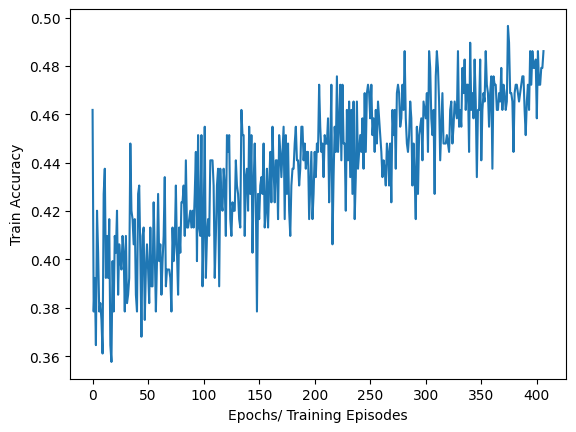

In [35]:
import matplotlib.pyplot as plt

plt.plot([i for i in range(len(ql.accuracy))], ql.accuracy)
plt.xlabel('Epochs/ Training Episodes')
plt.ylabel('Train Accuracy')
## next attempt: try putting the new token into target since it should be the future action thats being compared


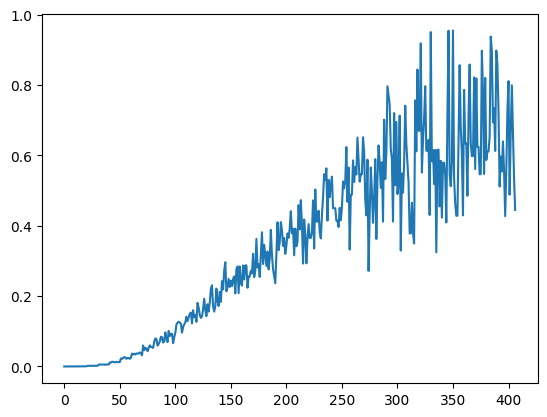

In [36]:
import matplotlib.pyplot as plt

plt.plot([i for i in range(len(ql.loss_))], ql.loss_)

## next attempt: try putting the new token into target since it should be the future action thats being compared

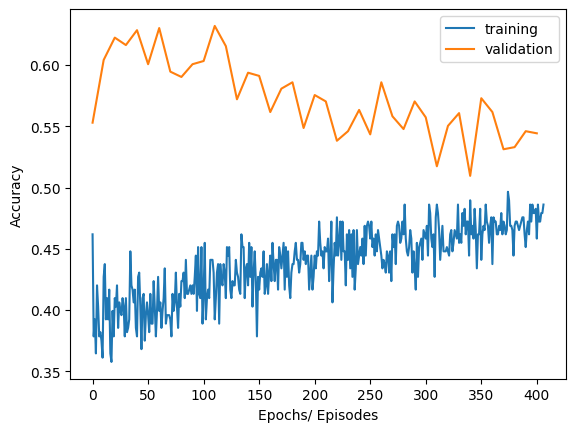

In [37]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(len(ql.accuracy))], ql.accuracy, label = 'training')
plt.plot([i*10 for i in range(len(ql.val_acc))], ql.val_acc, label = 'validation')
plt.xlabel('Epochs/ Episodes')
plt.ylabel('Accuracy')
plt.legend()
## next attempt: try putting the new token into target since it should be the future action thats being compared

In [ ]:
test_x = list(pd.read_csv('yelp_test')['text'].apply(lambda x: x[:1000]))
test_y = list(pd.read_csv('yelp_test')['label'])

with torch.no_grad():
    prompts, Q = ql.get_actions_Q_input_specific_target(val_x)
#     accuracy = ql.get_accuracy_(test_x, test_y, [' '.join(prompt) for prompt in prompts])

In [ ]:
print(ql.get_accuracy_(test_x, test_y, [' '.join(prompt) for prompt in prompts][1]))

In [ ]:
for ch in (''.join(prompts[0])):
    print(ord(ch))

In [ ]:
Q[0].softmax(-1).argmax(-1)

In [ ]:
ord(prompts[0][0][0])

In [ ]:
Q[0].softmax(-1).argmax(-1)

In [ ]:
ql.mlp.lm_pipeline.tokenizer.convert_ids_to_tokens([31204])

In [ ]:
type(ql.mlp.lm_pipeline.tokenizer)

In [ ]:
dir(ql.mlp.lm_pipeline.tokenizer)